In [139]:
# import libraries

import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns

In [5]:
# load dataset
spotify = pd.read_csv('spotify_2023.csv', encoding='latin1')

# Peeking at dataset & variables
print("Shape (rows, columns):\n", spotify.shape)
print("\nData Types:\n", spotify.dtypes)
print("\nHead:\n", spotify.head())
print("\nSummary Statistics:\n", spotify.describe())
print("\nMissing Values:\n", spotify.isnull().sum())



Shape (rows, columns):
 (953, 24)

Data Types:
 track_name              object
artist(s)_name          object
artist_count             int64
released_year            int64
released_month           int64
released_day             int64
in_spotify_playlists     int64
in_spotify_charts        int64
streams                 object
in_apple_playlists       int64
in_apple_charts          int64
in_deezer_playlists     object
in_deezer_charts         int64
in_shazam_charts        object
bpm                      int64
key                     object
mode                    object
danceability_%           int64
valence_%                int64
energy_%                 int64
acousticness_%           int64
instrumentalness_%       int64
liveness_%               int64
speechiness_%            int64
dtype: object

Head:
                             track_name    artist(s)_name  artist_count  \
0  Seven (feat. Latto) (Explicit Ver.)  Latto, Jung Kook             2   
1                                 LALA

# Initial Observations

- The dataset contains 953 songs with 24 features related to song metadata, popularity, and audio features.
- Some missing values in 'key' and 'in_shazam_charts'.
- Need to change some values from object to numeric.
- Release years range from 1930 - 2023, but most are after 2020 in this dataset.
- Streaming popularity
    - Mean streams is 5.2 million, but heavily skewed distributions due to outliers.
- Audio features
    - Average BPM is 122.
    - Most songs have danceability of above 60%.
    - Valence has lots of variation, but most songs have moderate positivity ~50%


In [168]:
# Data Cleaning

# converting object data types to numeric, and dropping missing values
spotify['streams'] = pd.to_numeric(spotify['streams'], errors='coerce')
spotify['in_deezer_playlists'] = pd.to_numeric(spotify['in_deezer_playlists'], errors='coerce')
spotify['in_shazam_charts'] = pd.to_numeric(spotify['in_shazam_charts'], errors='coerce')

# fill missing values
spotify['key'] = spotify['key'].fillna('n/a')
spotify['in_shazam_charts'] = spotify['in_shazam_charts'].fillna('0')

spotify.dtypes

track_name               object
artist(s)_name           object
artist_count              int64
released_year             int64
released_month            int64
released_day              int64
in_spotify_playlists      int64
in_spotify_charts         int64
streams                 float64
in_apple_playlists        int64
in_apple_charts           int64
in_deezer_playlists     float64
in_deezer_charts          int64
in_shazam_charts        float64
bpm                       int64
key                      object
mode                     object
danceability_%            int64
valence_%                 int64
energy_%                  int64
acousticness_%            int64
instrumentalness_%        int64
liveness_%                int64
speechiness_%             int64
dtype: object

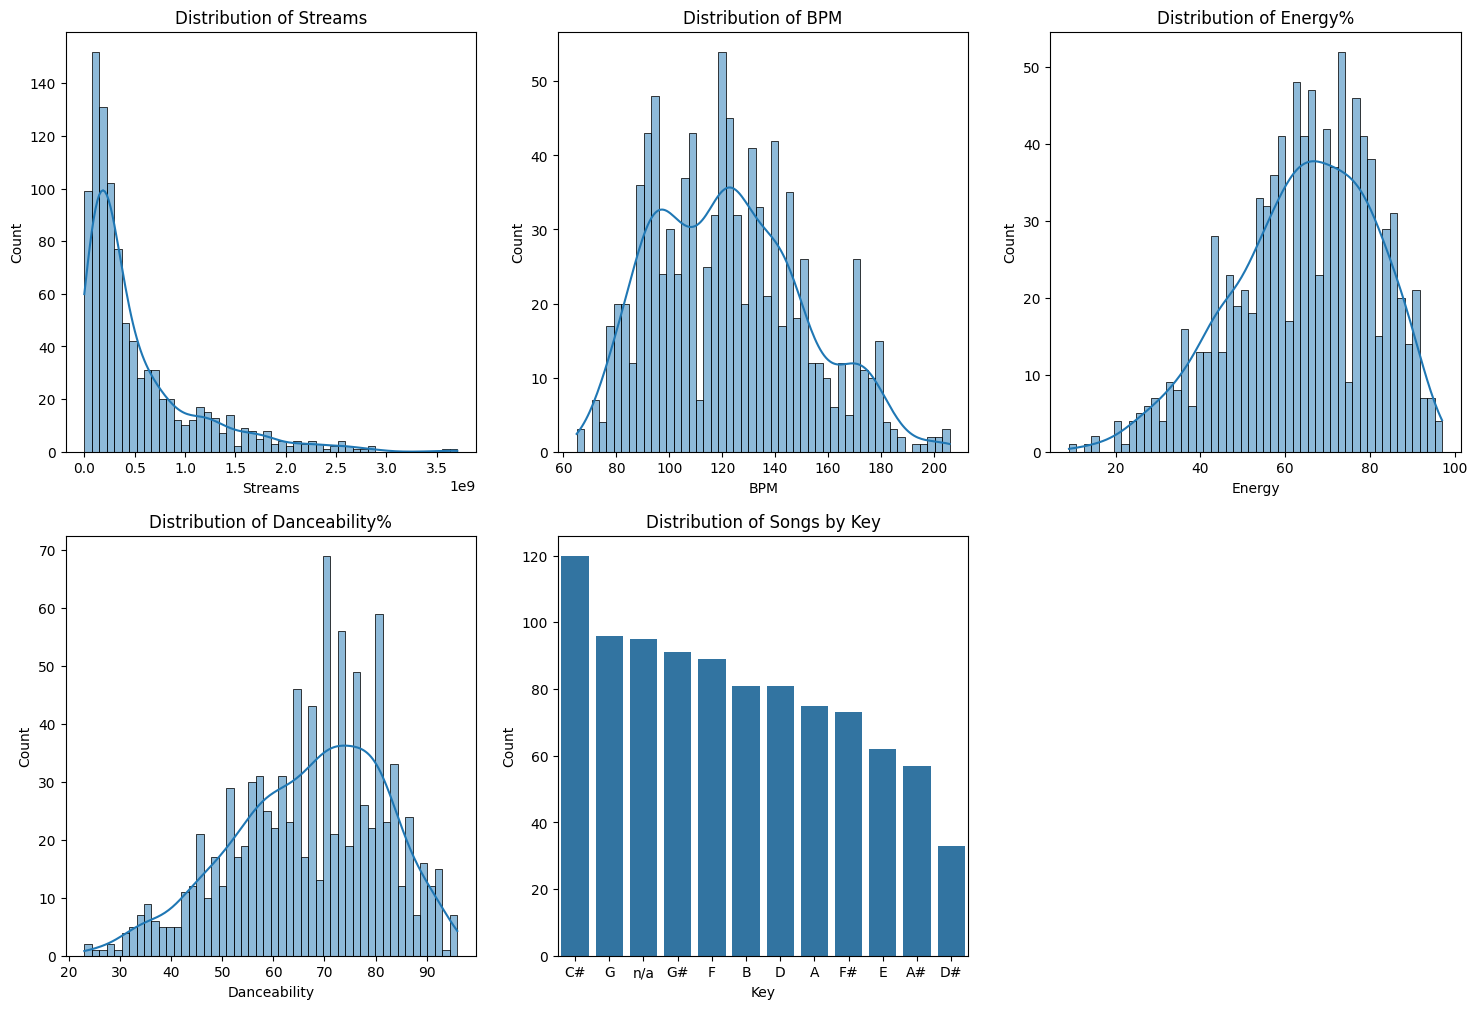

In [173]:
# Data Exploration

plt.figure(figsize=(18,12))

plt.subplot(2,3,1)
sns.histplot(spotify["streams"].dropna(), bins=50, kde=True)
plt.title("Distribution of Streams")
plt.xlabel("Streams")
plt.ylabel("Count")

plt.subplot(2,3,2)
sns.histplot(spotify["bpm"].dropna(), bins=50, kde=True)
plt.title("Distribution of BPM")
plt.xlabel("BPM")
plt.ylabel("Count")

plt.subplot(2,3,3)
sns.histplot(spotify["energy_%"].dropna(), bins=50, kde=True)
plt.title("Distribution of Energy%")
plt.xlabel("Energy")
plt.ylabel("Count")

plt.subplot(2,3,4)
sns.histplot(spotify["danceability_%"].dropna(), bins=50, kde=True)
plt.title("Distribution of Danceability%")
plt.xlabel("Danceability")
plt.ylabel("Count")

plt.subplot(2,3,5)
sns.barplot(x=spotify["key"].value_counts().index, y=spotify["key"].value_counts())
plt.title("Distribution of Songs by Key")
plt.xlabel("Key")
plt.ylabel("Count")
plt.show()




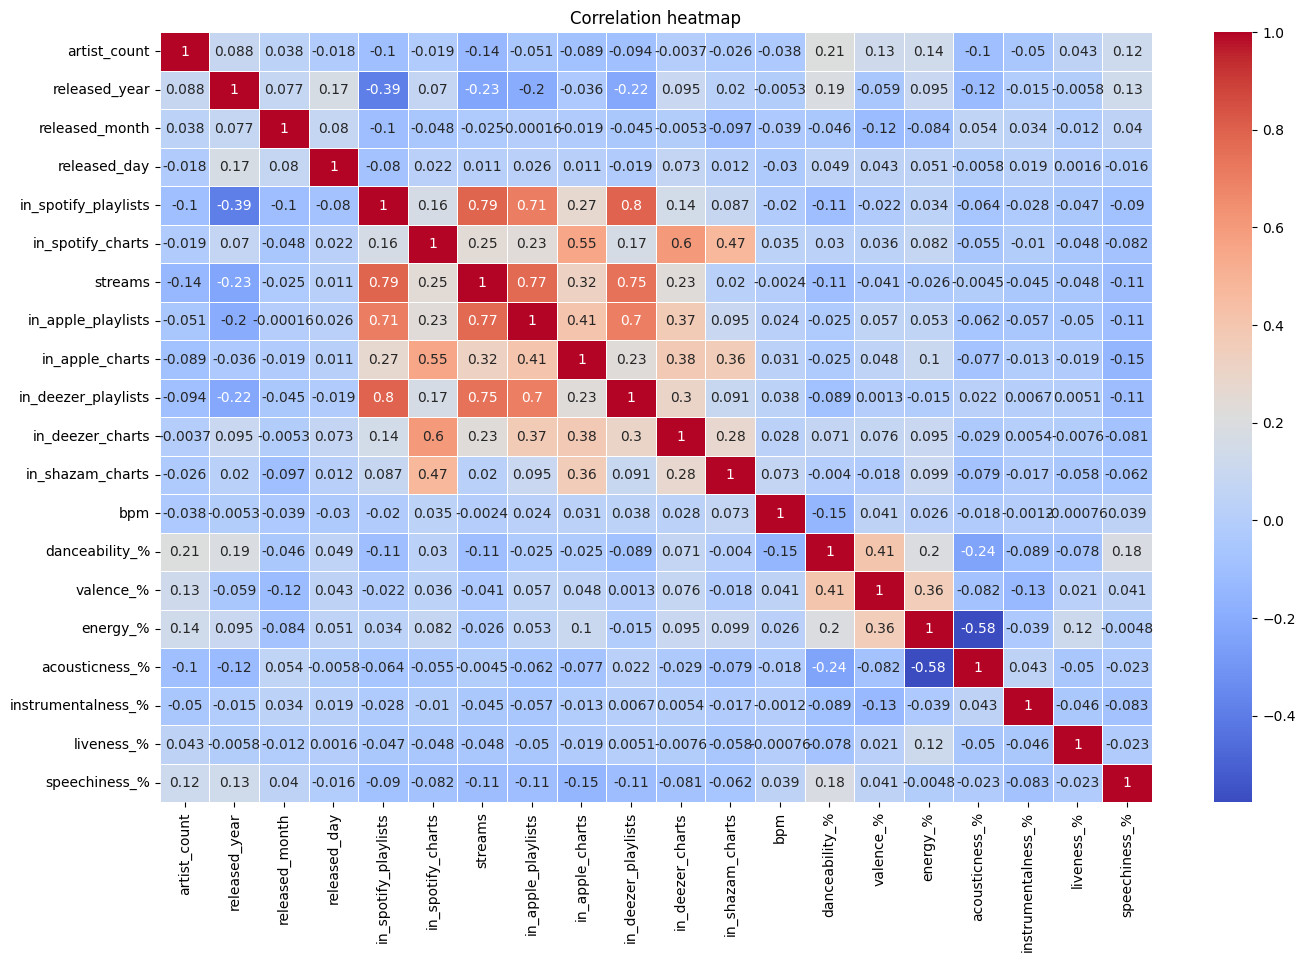

In [174]:
numeric_cols = spotify.select_dtypes(include=['number'])

# heatmap
plt.figure(figsize=(16, 10))
corr_matrix = numeric_cols.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation heatmap')
plt.show()

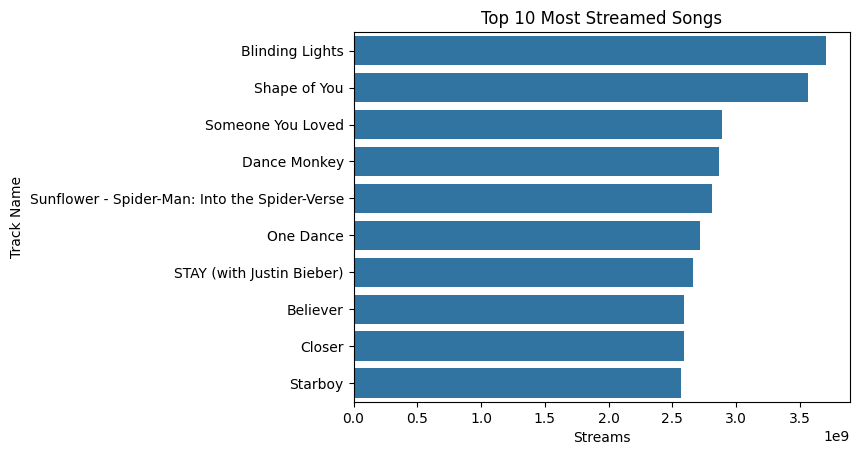

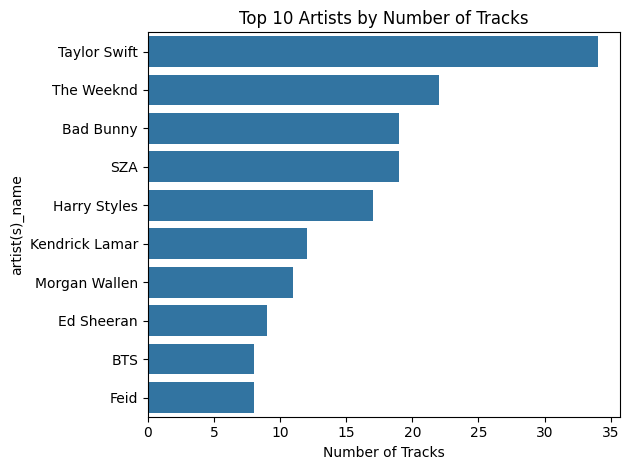

In [171]:
top_songs = spotify.nlargest(10, "streams")

sns.barplot(y=top_songs["track_name"], x=top_songs["streams"])
plt.xlabel("Streams")
plt.ylabel("Track Name")
plt.title("Top 10 Most Streamed Songs")
plt.show()
plt.close()

top_artists = spotify['artist(s)_name'].value_counts().head(10)
sns.barplot(x=top_artists.values, y=top_artists.index)
plt.title('Top 10 Artists by Number of Tracks')
plt.xlabel('Number of Tracks')
plt.tight_layout()
plt.show()

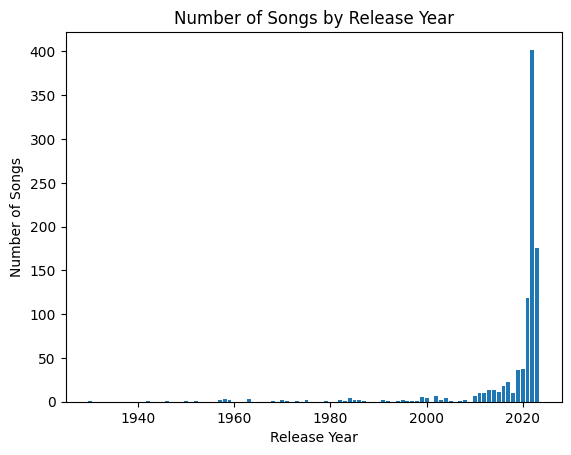

In [175]:
plt.bar(spotify['released_year'].value_counts().index, spotify['released_year'].value_counts().values)
plt.title('Number of Songs by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Songs')
plt.show()

# EDA Observations:


# Model Building:


In [20]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# Choose features based on your EDA insights
selected_features = ['bpm', 'energy_%', 'danceability_%']
# (Optionally, add more features or encode categorical variables like 'key')

# Ensure we drop any rows with missing values in these features
spotify_features = spotify[selected_features].dropna()

# Scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(spotify_features)

# Nearest Neighbors Model
# We set n_neighbors to 6 because the closest song is the song itself
knn = NearestNeighbors(n_neighbors=6, metric='cosine')
knn.fit(features_scaled)

# Function to Get Similar Songs
def get_similar_songs(song_index):
    # Get the feature vector for the target song
    song_vector = features_scaled[song_index].reshape(1, -1)
    distances, indices = knn.kneighbors(song_vector)
    # Exclude the first index (the song itself) to get the top 5 similar songs
    similar_song_indices = indices[0][1:]
    return spotify.iloc[similar_song_indices]

# Songs similar to the eigth song in dataset
similar_songs = get_similar_songs(7)
print(spotify.iloc[7]['track_name'])
print(spotify.iloc[7]['artist(s)_name'])
print(similar_songs[['track_name', 'artist(s)_name']])

Columbia
Quevedo
                                            track_name  \
859                                                295   
504                                        Out of Time   
398                                           Muï¿½ï¿½   
101  Too Many Nights (feat. Don Toliver & with Future)   
249                                 Oi Balde - Ao Vivo   

                        artist(s)_name  
859                   Sidhu Moose Wala  
504                         The Weeknd  
398        Steve Aoki, Tini, La Joaqui  
101  Future, Metro Boomin, Don Toliver  
249               Zï¿½ï¿½ Neto & Crist  
